In [4]:
import numpy as np

class Neural_Net:
    def __init__(self, layers):
        self.n_layers=len(layers)
        self.inputs=None
        self.outputs=None
        self.Layers=[]
        self.Weights=[]
        self.WGrads = []
        self.Bias=[]
        self.BGrads = []
        self.layers=layers
        self.learning_rate = 0
        self.n_inps = 0
        self.inputs_val = None
        self.outputs_val = None
        
    class Layer:
        def __init__(self, n_neurons):
            self.neurons = []
            self.n_neurons = n_neurons
            for i in range(self.n_neurons):
                self.neurons.append(Neuron())

        class Neuron:
            def __init__(self):
                self.type = 'relu'
                self.fp = 0
                self.z = 0
                self.W = []
                self.b = 0
                self.ac_1 = []
                self.dz=0

            def _weighted_sum(self):
                summ = 0
                for i in range(len(self.ac_1)):
                    summ+=self.ac_1[i]*self.W[i]
                return summ + self.b

            def _activation_fn(self):
                if(self.type=='relu'):
                    if self.z > 0:
                        return self.z
                    return 0
                elif(self.type=='sigm'):
                    return 1/(1+np.exp(-self.z))
                else:
                    raise Exception('Invalid Activation Function')

            def forward_propagate(self,inp,weights,bias,choice='relu'):
                assert(len(inp)==len(weights))
                self.type=choice
                self.ac_1 = inp
                self.W = weights
                self.b = bias
                self.z = self._weighted_sum()
                self.fp = self._activation_fn()
                return self.fp

            def _back_activation_fn(self):
                if(self.type=='relu'):
                    if(self.z<0):
                        return 0
                    else:
                        return self.dac
                elif(self.type=='sigm'):
                    return self.dac*self.fp*(1-self.fp)
                else:
                    raise Exception("Invalid activation function")

            def back_propagate(self,dac):
                self.dac = dac
                self.dz = self._back_activation_fn()
                m = len(self.ac_1)
                dw = np.array(self.ac_1)*self.dz
                db = self.dz
                dac_1 = np.array(self.W)*self.dz
                return dw,db,dac_1
            

        def forward_propagate(self, inputs, weights,bias,choice='relu'):
            output = []
            for i in range(self.n_neurons):
                output.append(self.neurons[i].forward_propagate(inputs,weights[i],bias[i],choice))
            return output

        def back_propagate(self,dacs):
            dacs=np.array(dacs.mean(axis=0))
            dws = []
            dbs = []
            dac_1s = []
            for i in range(dacs.shape[0]):
                temp1,temp2,temp3 = self.neurons[i].back_propagate(dacs[i])
                dws.append(temp1)
                dbs.append(temp2)
                dac_1s.append(temp3)
            return np.array(dws),np.array(dbs),np.array(dac_1s)
        
        
    def _showWandB(self):
        print('Weights:',self.Weights)
        print('Bias:',self.Bias)
        
    def _showGWandBG(self):
        print('WGrads:',self.WGrads)
        print('BGrads:',self.BGrads)
        
    def _initialize(self):
        for i in range(self.n_layers):
            self.Layers.append(Layer(self.layers[i]))
            if i==0:
                self.Weights.append(np.random.randn(self.layers[i],len(self.inputs[0])))#####
                self.Bias.append(np.random.randn(self.layers[0]))
            else:
                self.Weights.append(np.random.randn(self.layers[i],self.layers[i-1]))
                self.Bias.append(np.random.randn(self.layers[i]))
        self.Layers.append(Layer(1))
        self.Weights.append(np.random.randn(1,self.layers[self.n_layers-1]))
        self.Bias.append(np.random.randn(1))
                
    def _forward_propagate(self,temp):
        for i in range(len(self.Layers)):
            if i==0:
                temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],'relu')
            elif i==self.n_layers:
                temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],choice='sigm')
            else:
                temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],'relu')
        return temp
    
    def _compute_cost(self,pred,act,cost_type = 'crs_ent'):
        temp_out = np.array(pred)
        act=np.array(act)
        act = np.expand_dims(act,axis=0)
        m = act.shape[0]
        if(cost_type == 'mse'):
            cost = (1/(2*m))*(np.array(temp_out)-np.array(act))**2
            cost_der = np.array(temp_out)-np.array(act)
        elif(cost_type == 'crs_ent'):
#             print("m is ", m)
            if(temp_out==1):
                temp_out-=0.00001
            elif(temp_out==0):
                temp_out+=0.00001
            cost = (-1 / m) * (np.multiply(act, np.log(temp_out)) + np.multiply(1 - act, np.log(1 - temp_out)))
            cost_der =  (-1/m)* (np.divide(act, temp_out) - np.divide(1 - act, 1 - temp_out))
        else:
            raise Exception('Invalid cost function given.')
        return cost,cost_der
    
    def _back_propagate(self,cost_der):
        temp3 = np.array(cost_der)
        temp3 = np.expand_dims(temp3,axis=1)
        Wg = []
        Bg = []
        for i in reversed(range(len(self.Layers))):
            temp1, temp2, temp3 = self.Layers[i].back_propagate(temp3)
            Wg.insert(0,temp1)
            Bg.insert(0,temp2)
        return Wg,Bg
                
    def _update_weights(self):
        for i in range(len(self.Layers)):
            self.Weights[i] = self.Weights[i] - self.learning_rate * self.WGrads[i]
            self.Bias[i] = self.Bias[i] - self.learning_rate * self.BGrads[i]
     
    def train(self,inps,outs,inp_val,out_val,epochs=50,learning_rate = 0.03,printCost=False,printEvery = 10, printFrom = 0):
        self.inputs = inps
        self.outputs = outs
        self.inputs_val = inp_val
        self.outputs_val = out_val
        self.learning_rate = learning_rate
        self._initialize()
        cost_av = 0
        cost_der_av = 0
        self.n_inps = self.inputs.shape[0]
        costs = []
        trn_acc = []
        tst_acc = []
        WGtemp = []
        BGtemp = []
        xaxis = []
        for i in range(epochs):
            for j in range(len(self.inputs)):
                pred = self._forward_propagate(self.inputs[j])
#                 print(pred,end=" ")
                cost,cost_der = self._compute_cost(pred,self.outputs[j])
                WGtemp,BGtemp=self._back_propagate(cost_der)
                cost_av+=cost
                cost_der_av+=cost_der
                if(j==0):
                    self.WGrads = WGtemp
                    self.BGrads = BGtemp
                else:
                    for k in range(len(self.Layers)):
                        self.WGrads[k]=self.WGrads[k]+WGtemp[k]
                        self.BGrads[k]=self.BGrads[k]+BGtemp[k]
            for j in range(len(self.Layers)):
                self.WGrads[j]=self.WGrads[j]/self.n_inps
                self.BGrads[j]=self.BGrads[j]/self.n_inps
            cost_av/=self.n_inps
            cost_der_av/=self.n_inps
            if(printCost and i%printEvery==0 and i>=printFrom):# and i!=0 and i>10):
                print("Epoch %d/%d,"%(i+1,epochs),end=" ")
                print("Cost = %f,"%(cost_av),end=" ")
                _,acc1 = self.predict_classes(self.inputs,self.outputs)
                _,acc2 = self.predict_classes(self.inputs_val, self.outputs_val)
                print("Training Accuracy = %f, Validation Accuracy = %f"%(acc1,acc2))
                trn_acc.append(acc1)
                tst_acc.append(acc2)
                xaxis.append(i)
                costs.append(cost_av[0])
#             self._showGWandBG()
            self._update_weights()
        print("Epoch %d/%d,"%(epochs,epochs),end=" ")
        print("Cost = %f,"%(cost_av),end=" ")
        _,acc1 = self.predict_classes(self.inputs,self.outputs)
        _,acc2 = self.predict_classes(self.inputs_val, self.outputs_val)
        print("Training Accuracy = %f, Validation Accuracy = %f"%(acc1,acc2))
        
        plt.subplot(2, 1, 1)
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.title("Learning rate =" + str(self.learning_rate))
        
        plt.subplot(2, 1, 2)
        plt.plot(xaxis,trn_acc)
        plt.plot(xaxis,tst_acc)
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['Train Acc', 'Test Acc'])
        plt.title("Training and Test Acuuracies")
        
        plt.show()
        
        return costs
#         self._showWandB()
#         self._showGWandBG()

    def predict(self,p):
        preds = []
        for temp in p:
            for i in range(len(self.Layers)):
                if i==0:
                    temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],'relu')
                elif i==self.n_layers:
                    temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],choice='sigm')
                else:
                    temp = self.Layers[i].forward_propagate(temp,self.Weights[i],self.Bias[i],'relu')
            preds.append(temp)
        return preds
    
    def predict_classes(self,p,q):
        preds = np.array(self.predict(p))
        preds[preds>0.5]=1
        preds[preds<=0.5]=0
        preds = np.squeeze(preds)
        acc = np.sum((preds == q)/p.shape[0])
        return preds,acc

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('./diabetes.csv')

inputs = data.drop('Outcome', axis = 1)
inputs = np.array(inputs)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = MinMaxScaler()
inputs = sc.fit_transform(inputs)
outputs = data['Outcome'].as_matrix()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.10, random_state=42)

plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/home/rishi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


Epoch 11/400, Cost = 0.682927, Training Accuracy = 0.697540, Validation Accuracy = 0.701299
Epoch 12/400, Cost = 0.676974, Training Accuracy = 0.704776, Validation Accuracy = 0.688312
Epoch 13/400, Cost = 0.671505, Training Accuracy = 0.706223, Validation Accuracy = 0.688312
Epoch 14/400, Cost = 0.666443, Training Accuracy = 0.714906, Validation Accuracy = 0.688312
Epoch 15/400, Cost = 0.661745, Training Accuracy = 0.722142, Validation Accuracy = 0.714286
Epoch 16/400, Cost = 0.657380, Training Accuracy = 0.719247, Validation Accuracy = 0.727273
Epoch 17/400, Cost = 0.653305, Training Accuracy = 0.720695, Validation Accuracy = 0.740260
Epoch 18/400, Cost = 0.649482, Training Accuracy = 0.714906, Validation Accuracy = 0.727273
Epoch 19/400, Cost = 0.645897, Training Accuracy = 0.717800, Validation Accuracy = 0.727273
Epoch 20/400, Cost = 0.642526, Training Accuracy = 0.720695, Validation Accuracy = 0.727273
Epoch 21/400, Cost = 0.639317, Training Accuracy = 0.723589, Validation Accuracy

Epoch 101/400, Cost = 0.553282, Training Accuracy = 0.739508, Validation Accuracy = 0.727273
Epoch 102/400, Cost = 0.552903, Training Accuracy = 0.739508, Validation Accuracy = 0.727273
Epoch 103/400, Cost = 0.552531, Training Accuracy = 0.740955, Validation Accuracy = 0.727273
Epoch 104/400, Cost = 0.552166, Training Accuracy = 0.740955, Validation Accuracy = 0.727273
Epoch 105/400, Cost = 0.551802, Training Accuracy = 0.740955, Validation Accuracy = 0.727273
Epoch 106/400, Cost = 0.551433, Training Accuracy = 0.739508, Validation Accuracy = 0.727273
Epoch 107/400, Cost = 0.551067, Training Accuracy = 0.738061, Validation Accuracy = 0.727273
Epoch 108/400, Cost = 0.550709, Training Accuracy = 0.738061, Validation Accuracy = 0.727273
Epoch 109/400, Cost = 0.550357, Training Accuracy = 0.739508, Validation Accuracy = 0.727273
Epoch 110/400, Cost = 0.550011, Training Accuracy = 0.738061, Validation Accuracy = 0.727273
Epoch 111/400, Cost = 0.549671, Training Accuracy = 0.739508, Validati

Epoch 190/400, Cost = 0.529069, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 191/400, Cost = 0.528844, Training Accuracy = 0.749638, Validation Accuracy = 0.740260
Epoch 192/400, Cost = 0.528622, Training Accuracy = 0.749638, Validation Accuracy = 0.740260
Epoch 193/400, Cost = 0.528403, Training Accuracy = 0.751085, Validation Accuracy = 0.740260
Epoch 194/400, Cost = 0.528186, Training Accuracy = 0.751085, Validation Accuracy = 0.740260
Epoch 195/400, Cost = 0.527972, Training Accuracy = 0.753980, Validation Accuracy = 0.740260
Epoch 196/400, Cost = 0.527760, Training Accuracy = 0.753980, Validation Accuracy = 0.740260
Epoch 197/400, Cost = 0.527550, Training Accuracy = 0.753980, Validation Accuracy = 0.740260
Epoch 198/400, Cost = 0.527343, Training Accuracy = 0.753980, Validation Accuracy = 0.740260
Epoch 199/400, Cost = 0.527138, Training Accuracy = 0.753980, Validation Accuracy = 0.740260
Epoch 200/400, Cost = 0.526934, Training Accuracy = 0.753980, Validati

Epoch 279/400, Cost = 0.511244, Training Accuracy = 0.762663, Validation Accuracy = 0.753247
Epoch 280/400, Cost = 0.511080, Training Accuracy = 0.762663, Validation Accuracy = 0.753247
Epoch 281/400, Cost = 0.510918, Training Accuracy = 0.762663, Validation Accuracy = 0.753247
Epoch 282/400, Cost = 0.510757, Training Accuracy = 0.762663, Validation Accuracy = 0.753247
Epoch 283/400, Cost = 0.510597, Training Accuracy = 0.762663, Validation Accuracy = 0.753247
Epoch 284/400, Cost = 0.510436, Training Accuracy = 0.762663, Validation Accuracy = 0.753247
Epoch 285/400, Cost = 0.510275, Training Accuracy = 0.761216, Validation Accuracy = 0.753247
Epoch 286/400, Cost = 0.510114, Training Accuracy = 0.761216, Validation Accuracy = 0.753247
Epoch 287/400, Cost = 0.509954, Training Accuracy = 0.761216, Validation Accuracy = 0.753247
Epoch 288/400, Cost = 0.509795, Training Accuracy = 0.761216, Validation Accuracy = 0.753247
Epoch 289/400, Cost = 0.509637, Training Accuracy = 0.759768, Validati

Epoch 368/400, Cost = 0.496256, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 369/400, Cost = 0.496073, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 370/400, Cost = 0.495889, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 371/400, Cost = 0.495707, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 372/400, Cost = 0.495525, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 373/400, Cost = 0.495344, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 374/400, Cost = 0.495166, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 375/400, Cost = 0.494989, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 376/400, Cost = 0.494815, Training Accuracy = 0.758321, Validation Accuracy = 0.714286
Epoch 377/400, Cost = 0.494641, Training Accuracy = 0.758321, Validation Accuracy = 0.727273
Epoch 378/400, Cost = 0.494469, Training Accuracy = 0.758321, Validati

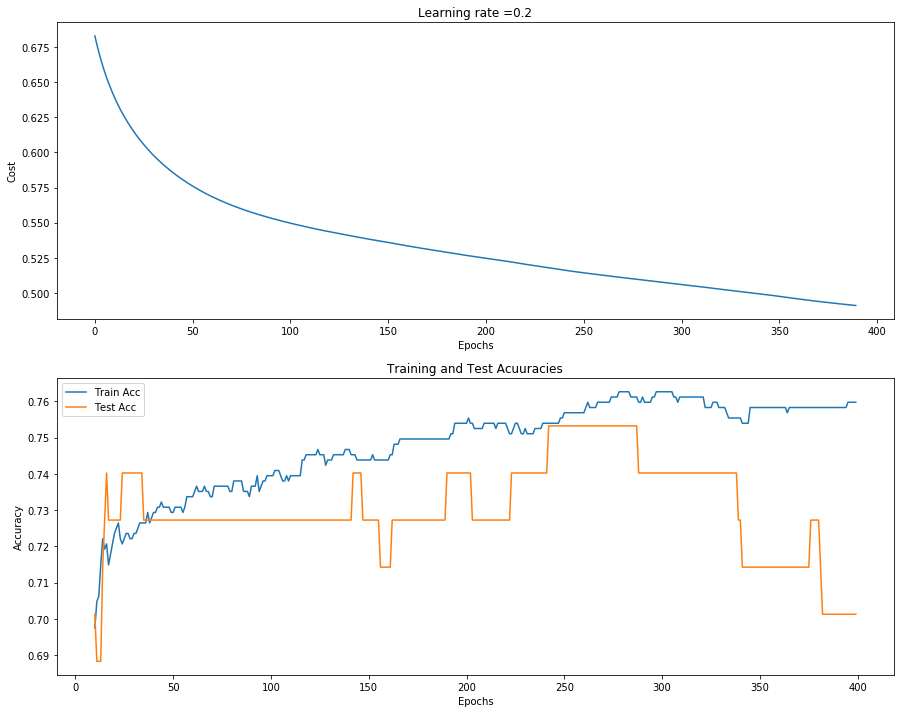

In [6]:
np.random.seed(10)
net = Neural_Net([10,5])
costs = net.train(X_train,y_train,X_test,y_test,epochs=400,learning_rate=0.2,printCost=True,printEvery=1, printFrom = 10)

In [21]:
# import pandas as pd
# import numpy as np

# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# data = pd.read_csv('./dataR2 (copy).csv')

# inputs = data.drop('Classification', axis = 1)
# inputs = np.array(inputs)

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# sc = MinMaxScaler()
# inputs = sc.fit_transform(inputs)
# outputs = data['Classification'].as_matrix()

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.10, random_state=42)

# plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [22]:
# np.random.seed(10)
# net2 = Neural_Net([10,5])
# costs = net2.train(X_train,y_train,X_test,y_test,epochs=400,learning_rate=0.05,printCost=True,printEvery=1)

In [23]:
# import pandas as pd
# import numpy as np

# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# data = pd.read_csv('./SomeRandomPaperDataset.csv')
# data = np.array(data.as_matrix()).T
# data = pd.DataFrame(data)
# lst = data.columns

# inputs = data.drop([45033], axis = 1)
# inputs = np.array(inputs)

# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# sc = MinMaxScaler()
# inputs = sc.fit_transform(inputs)
# outputs = data[45033].as_matrix()

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.10, random_state=301)

# plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [24]:
# X_train.shape

In [25]:
# np.random.seed(10)
# net3 = Neural_Net([45,45,45,45])
# costs = net3.train(X_train,y_train,X_test,y_test,epochs=100,learning_rate=0.1,printCost=True,printEvery=1)